# Aprendizaje Automático - Práctica 3 - Ajuste de Modelos Lineales

# Problema de Clasificación

#### Valoración máxima: 6 puntos

#### Fecha límite de entrega: 4 de Junio de 2023 a las 23:59

#### Entrega a través de https://pradogrado2223.ugr.es/

### Nombre completo: <mark>Yeray López Ramírez</mark>



---

In [ ]:
import numpy as np  # Vectores
import pandas as pd  # Dataframes
from matplotlib import pyplot as plt  # Gráficas
import seaborn as sns  # Gráficas más completas
from IPython.display import display, Latex, Markdown  # Tablas

# Funciones SKLEARN

from sklearn.model_selection import cross_val_predict # Validacion cruzada

# Modelos
from sklearn.decomposition import PCA # PCA
from sklearn.svm import OneClassSVM # Support Vector Machine
from sklearn.linear_model import LogisticRegression # Logistic Regression

from sklearn.model_selection import train_test_split  # División de datos

# Normalización
from sklearn.preprocessing import StandardScaler  # Media 0 y desviación estándar 1

# Métricas
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score  # Exactitud
from sklearn.metrics import confusion_matrix  # Matriz de confusión
from sklearn.metrics import precision_score  # Precisión
from sklearn.metrics import recall_score  # Exhaustividad o sensibilidad
from sklearn.metrics import f1_score  # Valor F1

from sklearn.feature_selection import VarianceThreshold # Varianza
from sklearn.model_selection import learning_curve  # Curva de Aprendizaje

# Fijar semilla
np.random.seed(1)

In [ ]:
#Tamaño de fuente para las gráficas
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
TITLE_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=TITLE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

**Normas de desarrollo y entrega de trabajos**

- Única y exclusivamente se debe entregar este Notebook de Colab (fichero .ipynb). No es necesario entregar ninguna memoria externa, pero el código debe estar bien comentado, y todas las decisiones tomadas y el trabajo desarrollado deben documentarse suficientemente en celdas de texto.

- La entrega en PRADO está configurada para permitir sucesivas entregas de la práctica. Desde este punto de vista, se recomienda subir versiones de la práctica a medida que se van realizando los distintos ejercicios propuestos, y no dejarlo todo para el final, dado que es altamente improbable que se extienda la fecha de entrega.

- Reiterar que es obligatorio documentar las valoraciones y decisiones adoptadas en el desarrollo de cada uno de los apartados. Debe incluirse también una valoración razonada sobre la calidad de los
resultados obtenidos. Sin esta documentación, se considera que el trabajo NO ha sido presentado.

- Se debe respetar la estructura y secciones del Notebook. Esto servirá para agilizar las correcciones, así como para identificar con facilidad qué ejercicio/apartado se está respondiendo.

- El codigo NO puede escribir nada a disco.

- Se espera que el código siempre lea de un directorio llamado 'drive/MyDrive/Colab Notebooks/datos/', situado dentro del directorio donde se desarrolla y ejecuta la práctica. No se admiten excepciones a esta ruta de acceso a los datos.

- Una entrega es apta para ser corregida si se puede ejecutar de principio a fin sin errores.

- No es válido usar opciones en las entradas (es decir, utilizar el comando `input`, por ejemplo, para que el usuario escoja el valor de las variables para ejecutar el programa). Para ello, se deben fijar al comienzo los valores
por defecto que se consideren óptimos o que se soliciten en el enunciado.

- El código debe estar obligatoriamente comentado explicando lo que realizan los distintos apartados y/o bloques.

- Se entrega solamente este Notebook, y no los datos empleados.


---

<font color='blue'>Este trabajo  se centra en el ajuste y selección del mejor predictor lineal para un conjunto de datos dado. Para ello, se recomienda el uso de la librería Scikit-Learn (https://scikit-learn.org/). Esta librería contiene funciones de alto nivel que pueden ser muy útiles para el desarrollo de la práctica. En cualquier caso, para cada función de Scikit-Learn que se use, debe explicar por qué es necesario su uso, así como explicar su funcionamiento y el significado de todos sus parámetros. En relación con este punto, los valores por defecto en la librería no se consideran elecciones justificadas $\textit{a priori}$ y, al igual que en el resto de la práctica, decisiones sin justificación y resultados sin interpretación no serán considerados válidos.



In [ ]:
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
# La carpeta datos (que contiene OnlineNewsPopularity.csv, OnlineNewsPopularity.names)
# debe estar en vuestro Drive, dentro de la carpeta 'Colab Notebooks'
ruta = 'drive/MyDrive/Colab Notebooks/datos/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Función auxiliar que permite la lectura de un fichero y lo estructura en un
# dataframe
def leer_datos(archivo, separador=";", header=None): # Por defecto el separador es ;
    # Los datos se guardan en un dataframe
    """
    IMPORTANTE. Al generar un dataframe con pandas usando
    la lectura de ficheros, la primera fila actuará como la cabecera del mismo
    Hay que indicarle que no hay cabecera si el fichero no la tiene.
    En este caso, el fichero de regresión contiene una primera fila como la cabecera
    """
    if header is None:
      datos = pd.read_csv(archivo, sep=separador, header=None, skipinitialspace=True)
    else:
      datos = pd.read_csv(archivo, sep=separador, skipinitialspace=True)

    return datos

In [ ]:
# Operaciones con dataframes

# Une vectores de datos y objetivo en un dataframe
def join_(X,Y, cols=None):
  joined_data = np.column_stack((X, Y))

  # Crear un DataFrame de train
  return pd.DataFrame(joined_data, columns=cols)

# Une dataframes de datos y objetivo
def rejoin_(X,Y, axis=1):
  return pd.concat([X,Y], axis=axis, join='inner')

# Obtiene componentes X o Y de un dataframe
def X_(X):
  return X.iloc[:, :-1]
def Y_(X):
  return X.iloc[:, -1]

In [ ]:
# Función que separa la muestra en sus características y objetivo
def separar_datos(data):
    valores = data.values

    # Todas las columnas excepto la última son los valores a usar (X)
    X = valores[:, 0:-1]

    # La última columna son los valores a predecir (Y)
    Y = valores[:, -1]

    return X, Y

In [ ]:
# Cuenta el número de veces que aparece un rango de articulos compartidos y hace un muestreo
# Servirá para ver qué tan balanceados están los datos
def show_histogram(data, titulo, xlabel, ylabel, fontsize=12):
    fig, ax = plt.subplots(figsize=(20,10))

    # Obtener los valores de la columna objetivo
    ctarget = data['CARAVAN'].value_counts()

    # Calcular total
    total = ctarget.sum()

    # Calcular el porcentaje de datos en cada barra
    porcentaje = ctarget / total * 100

    # Crear el histograma utilizando seaborn
    sns.barplot(x=ctarget.index, y=ctarget.values)

    #plt.xticks(rotation=0)  # Rotación de 90 grados para las etiquetas del eje x

    # Mostrar el porcentaje en cada barra del histograma
    for i, v in enumerate(porcentaje):
      ax.text(i, int(ctarget.values[i]/2), f'{v:.2f}%', ha='center', va='bottom', rotation='horizontal', fontsize=fontsize)

    # Etiquetas y título
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo + '. Intervalos de ' + str(intervalo) + ' en ' + str(intervalo))

    # Mostrar el histograma
    plt.show()

In [ ]:
# Calculo de variables continuas
# display(regress_data.describe()) # muestra una tabla similar
def crear_tabla_valores(Train):
  media = Train.mean()   # Media
  mediana = Train.median()   # Mediana
  desviacion_tipica = Train.std()   # Desviación estándar
  minimo = Train.min()   # Mínimo
  maximo = Train.max()   # Máximo
  per = [0.1, 0.25, 0.50, 0.75, 0.9];   # Percentiles
  percentiles = Train.quantile(per)

  # Crea un nuevo DataFrame con los valores calculados
  tabla_valores = pd.DataFrame({
      'Media': media,
      'Mediana': mediana,
      'Desviación típica': desviacion_tipica,
      'Mínimo': minimo,
      'Máximo': maximo
  })

  # Agrega los percentiles al DataFrame
  for p in per:
      tabla_valores[f'Percentil {p*100}'] = percentiles.loc[p]

  return tabla_valores

#### <font color='blue'>1)  Analizar y describir adecuadamente el problema a resolver. Identificar los elementos $X$, $Y$ and $f$ del problema, y describirlos en detalle. 0.5 puntos.

El problema a resolver en el conjunto de datos **Insurance Company Benchmark** es predecir la prima de seguros para diferentes perfiles de clientes basados en un conjunto de atributos relacionados. Este conjunto de datos consta de un total de 9000 instancias (artículos) y 86 atributos.

El conjunto de datos Insurance Company Benchmark contiene información sobre diferentes perfiles de clientes, como edad, género, estado civil, ingresos, número de hijos, tipo de trabajo, entre otros. También incluye atributos relacionados con la póliza de seguros, como el tipo de cobertura, la duración de la póliza, la suma asegurada, entre otros.

El objetivo principal es utilizar estos atributos para predecir la prima de seguros para cada perfil de cliente. La prima de seguros es el monto que un cliente debe pagar periódicamente a la compañía de seguros para mantener su póliza activa.

Por lo tanto, la función objetivo del problema se define como f: $\mathcal{X} \rightarrow \mathcal{Y}$, donde $\mathcal{X}$ representa el conjunto de atributos del perfil del cliente y $\mathcal{Y}$ representa la prima de seguros correspondiente.

El objetivo final es construir un modelo de aprendizaje automático que pueda aprender a partir de los datos proporcionados y realizar predicciones precisas sobre la prima de seguros para perfiles de clientes no vistos. Esto permitirá a las compañías de seguros tener una estimación más precisa de las primas para diferentes perfiles de clientes y ajustar sus estrategias de precios en consecuencia. Además, también puede ayudar a los clientes a comprender mejor cómo se determina su prima de seguros y tomar decisiones informadas al elegir una póliza.

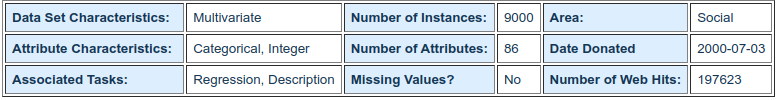

In [ ]:
# Lectura de datos y previsualizacion
file_data = ruta + "ticdata2000.txt" # Entrenamiento
file_eval = ruta + "ticeval2000.txt" # Test sin target
file_tgts = ruta + "tictgts2000.txt" # Targets test

# Leer los datos
classification_data = leer_datos(file_data, "\t")
classification_eval = leer_datos(file_eval, "\t")
classification_tgts = leer_datos(file_tgts, "\t")

# Asignamos el número de columna en test
classification_tgts = classification_tgts.rename(columns={0: 85})

print(f"Dimensiones del dataset de entrenamiento (ejemplos, atributos): {classification_data.shape}")
print(f"Dimensiones del dataset de evaluación (ejemplos, atributos): {classification_eval.shape}")
print(f"Dimensiones del cojunto de target (ejemplos): {classification_tgts.shape}")

# Concatenar datos de evaluacion con la etiqueta
full_classification_eval = rejoin_(classification_eval, classification_tgts)
print(f"\nDimensiones del dataset de test (ejemplos, atributos): {full_classification_eval.shape}")

# Concatenar datos de entrenamiento y test
full_classification_data = rejoin_(classification_data, full_classification_eval, axis=0)

# Mezclar las filas aleatoriamente
data_class = full_classification_data.sample(frac=1, random_state=33)

# Limpiar indices
data_class = data_class.reset_index(drop=True)

Dimensiones del dataset de entrenamiento (ejemplos, atributos): (5822, 86)
Dimensiones del dataset de evaluación (ejemplos, atributos): (4000, 85)
Dimensiones del cojunto de target (ejemplos): (4000, 1)

Dimensiones del dataset de test (ejemplos, atributos): (4000, 86)


In [ ]:
# Asignar nombres a las columnas
# Lo escribiría en un fichero y lo leería de forma externa pero no se permite
# escribir nada

atributos = {
  0 : "MOSTYPE", # Customer Subtype see L0
  1 : "MAANTHUI", # Number of houses 1 � 10
  2 : "MGEMOMV", # Avg size household 1 � 6
  3 : "MGEMLEEF", # Avg age see L1
  4 : "MOSHOOFD", # Customer main type see L2
  5 : "MGODRK", # Roman catholic see L3
  6 : "MGODPR", # Protestant ...
  7 : "MGODOV", # Other religion
  8 : "MGODGE", # No religion
  9 : "MRELGE", # Married
  10 : "MRELSA", # Living together
  11 : "MRELOV", # Other relation
  12 : "MFALLEEN", # Singles
  13 : "MFGEKIND", # Household without children
  14 : "MFWEKIND", # Household with children
  15 : "MOPLHOOG", # High level education
  16 : "MOPLMIDD", # Medium level education
  17 : "MOPLLAAG", # Lower level education
  18 : "MBERHOOG", # High status
  19 : "MBERZELF", # Entrepreneur
  20 : "MBERBOER", # Farmer
  21 : "MBERMIDD", # Middle management
  22 : "MBERARBG", # Skilled labourers
  23 : "MBERARBO", # Unskilled labourers
  24 : "MSKA", # Social class A
  25 : "MSKB1", # Social class B1
  26 : "MSKB2", # Social class B2
  27 : "MSKC", # Social class C
  28 : "MSKD", # Social class D
  29 : "MHHUUR", # Rented house
  30 : "MHKOOP", # Home owners
  31 : "MAUT1", # 1 car
  32 : "MAUT2", # 2 cars
  33 : "MAUT0", # No car
  34 : "MZFONDS", # National Health Service
  35 : "MZPART", # Private health insurance
  36 : "MINKM30", # Income < 30.000
  37 : "MINK3045", # Income 30-45.000
  38 : "MINK4575", # Income 45-75.000
  39 : "MINK7512", # Income 75-122.000
  40 : "MINK123M", # Income >123.000
  41 : "MINKGEM", # Average income
  42 : "MKOOPKLA", # Purchasing power class
  43 : "PWAPART", # Contribution private third party insurance see L4
  44 : "PWABEDR", # Contribution third party insurance (firms) ...
  45 : "PWALAND", # Contribution third party insurane (agriculture)
  46 : "PPERSAUT", # Contribution car policies
  47 : "PBESAUT", # Contribution delivery van policies
  48 : "PMOTSCO", # Contribution motorcycle/scooter policies
  49 : "PVRAAUT", # Contribution lorry policies
  50 : "PAANHANG", # Contribution trailer policies
  51 : "PTRACTOR", # Contribution tractor policies
  52 : "PWERKT", # Contribution agricultural machines policies
  53 : "PBROM", # Contribution moped policies
  54 : "PLEVEN", # Contribution life insurances
  55 : "PPERSONG", # Contribution private accident insurance policies
  56 : "PGEZONG", # Contribution family accidents insurance policies
  57 : "PWAOREG", # Contribution disability insurance policies
  58 : "PBRAND", # Contribution fire policies
  59 : "PZEILPL", # Contribution surfboard policies
  60 : "PPLEZIER", # Contribution boat policies
  61 : "PFIETS", # Contribution bicycle policies
  62 : "PINBOED", # Contribution property insurance policies
  63 : "PBYSTAND", # Contribution social security insurance policies
  64 : "AWAPART", # Number of private third party insurance 1 - 12
  65 : "AWABEDR", # Number of third party insurance (firms) ...
  66 : "AWALAND", # Number of third party insurane (agriculture)
  67 : "APERSAUT", # Number of car policies
  68 : "ABESAUT", # Number of delivery van policies
  69 : "AMOTSCO", # Number of motorcycle/scooter policies
  70 : "AVRAAUT", # Number of lorry policies
  71 : "AAANHANG", # Number of trailer policies
  72 : "ATRACTOR", # Number of tractor policies
  73 : "AWERKT", # Number of agricultural machines policies
  74 : "ABROM", # Number of moped policies
  75 : "ALEVEN", # Number of life insurances
  76 : "APERSONG", # Number of private accident insurance policies
  77 : "AGEZONG", # Number of family accidents insurance policies
  78 : "AWAOREG", # Number of disability insurance policies
  79 : "ABRAND", # Number of fire policies
  80 : "AZEILPL", # Number of surfboard policies
  81 : "APLEZIER", # Number of boat policies
  82 : "AFIETS", # Number of bicycle policies
  83 : "AINBOED", # Number of property insurance policies
  84 : "ABYSTAND", # Number of social security insurance policies
  85 : "CARAVAN" # Number of mobile home policies 0 - 1]
}

In [ ]:
# Utiliza el método rename() para asignar los nombres de columna al DataFrame
data_class = data_class.rename(columns=atributos)

# Visualizar datos
display(data_class.head())

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,38,1,3,3,9,1,6,2,2,7,...,0,0,0,0,0,0,0,0,0,0
1,22,1,1,2,5,0,5,2,2,1,...,0,0,0,1,0,0,0,0,0,0
2,2,1,2,3,1,1,5,1,3,5,...,0,0,0,0,0,0,0,0,0,0
3,33,1,3,4,8,0,4,0,5,5,...,0,0,0,0,0,0,0,0,0,0
4,36,1,2,3,8,0,3,0,6,3,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Podemos ver más sobre cada atributo: tipo y valores nulos
# En el dataset nos dicen que no hay valores faltantes
print("\n\tComo el shape del dataframe contiene las mismas columnas se puede intuir que no hay datos erroneos")
print(data_class.info())

print("Se consideran MOSTYPE y MOSHOOFD como categóricas, ahora se explica por qué.")
categoricas = ["MOSTYPE", "MOSHOOFD"] # Identifican tipo y subtipo de cliente
# El resto de variables son numéricas aunque se podrían considerar ciertas categorías


	Como el shape del dataframe contiene las mismas columnas se puede intuir que no hay datos erroneos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   MOSTYPE   9822 non-null   int64
 1   MAANTHUI  9822 non-null   int64
 2   MGEMOMV   9822 non-null   int64
 3   MGEMLEEF  9822 non-null   int64
 4   MOSHOOFD  9822 non-null   int64
 5   MGODRK    9822 non-null   int64
 6   MGODPR    9822 non-null   int64
 7   MGODOV    9822 non-null   int64
 8   MGODGE    9822 non-null   int64
 9   MRELGE    9822 non-null   int64
 10  MRELSA    9822 non-null   int64
 11  MRELOV    9822 non-null   int64
 12  MFALLEEN  9822 non-null   int64
 13  MFGEKIND  9822 non-null   int64
 14  MFWEKIND  9822 non-null   int64
 15  MOPLHOOG  9822 non-null   int64
 16  MOPLMIDD  9822 non-null   int64
 17  MOPLLAAG  9822 non-null   int64
 18  MBERHOOG  9822 non-null   int64
 19  MBERZELF  

Tenemos 9822 ejemplos y 86 atributos. La última (`CARAVAN`) es el valor a predecir. Hay ciertos bloques de datos que se identifican:

- **Tipo y subtipo de cliente:** Esta categoría proporciona información sobre los diferentes tipos y subtipos de clientes según el segmento al que pertenecen.
Hay 2 atributos en el bloque: MOSTYPE y MOSHOOFD que dada su naturaleza se consideran **CATEGÓRICOS**.

- **Información sobre el hogar:** Esta categoría incluye atributos relacionados con el hogar, como el número de casas en el hogar, el tamaño promedio o si es de alquiler o no.

- **Religión:** Estos atributos indican la distribución de las creencias religiosas en la región, como el porcentaje de católicos romanos, protestantes, personas con otras religiones y personas sin religión.

- **Estado civil:** Esta categoría muestra la composición del estado civil de los individuos, incluyendo el porcentaje de personas casadas, viviendo juntas, en otras relaciones y solteras.

- **Educación:** Estos atributos reflejan el nivel educativo de las personas, como el porcentaje de personas con educación de alto nivel, medio nivel y bajo nivel.

- **Estatus social:** Esta categoría proporciona información sobre el estatus social de los individuos, como el porcentaje de personas en una posición social alta, emprendedores, granjeros y en puestos de gerencia intermedia.

- **Coche:** Estos atributos describen la propiedad de automóviles en los hogares, como el porcentaje de hogares con 1 automóvil, 2 automóviles o sin automóviles.

- **Salud:** Estos atributos indican la contribución a servicios de salud, como el porcentaje de personas que contribuyen al servicio de salud nacional y tienen seguro de salud privado.

- **Ingresos:** Esta categoría incluye atributos relacionados con los ingresos de las personas, como diferentes rangos de ingresos, ingreso promedio, etc.

- **Contribución a pólizas:** Estos atributos representan la contribución a diferentes tipos de pólizas, como pólizas privadas de terceros, pólizas de terceros para empresas, pólizas de terceros para agricultura, etc.

- **Número de pólizas:** Esta categoría proporciona información sobre el número de pólizas que poseen los individuos en diferentes categorías, como pólizas de automóviles, pólizas de vida, pólizas de propiedad, etc.

Estos bloques de información nos brindan una visión completa de los diferentes aspectos demográficos, económicos y de estilo de vida de los clientes en el conjunto de datos Insurance Company Benchmark.

In [ ]:
# antes es necesario convertir las variables categóricas en numéricas
print(f"{categoricas}")

display(data_class)
target = Y_(data_class)

X_data_class = pd.get_dummies(X_(data_class), columns = categoricas, drop_first = True)

data_class = rejoin_(X_data_class, target)
print("Se han transformado los datos...\n")
display(data_class.head())

['MOSTYPE', 'MOSHOOFD']


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,38,1,3,3,9,1,6,2,2,7,...,0,0,0,0,0,0,0,0,0,0
1,22,1,1,2,5,0,5,2,2,1,...,0,0,0,1,0,0,0,0,0,0
2,2,1,2,3,1,1,5,1,3,5,...,0,0,0,0,0,0,0,0,0,0
3,33,1,3,4,8,0,4,0,5,5,...,0,0,0,0,0,0,0,0,0,0
4,36,1,2,3,8,0,3,0,6,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9817,12,1,3,2,3,0,6,0,3,7,...,0,0,1,1,0,0,0,0,0,1
9818,33,1,2,3,8,0,7,2,0,9,...,0,0,0,0,0,0,0,0,0,0
9819,12,1,4,2,3,0,7,2,0,9,...,0,0,0,0,0,0,0,0,0,0
9820,38,1,3,3,9,1,6,2,2,7,...,0,0,0,0,0,0,0,0,0,0


Se han transformado los datos...



,MAANTHUI,MGEMOMV,MGEMLEEF,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,...,MOSHOOFD_2,MOSHOOFD_3,MOSHOOFD_4,MOSHOOFD_5,MOSHOOFD_6,MOSHOOFD_7,MOSHOOFD_8,MOSHOOFD_9,MOSHOOFD_10,CARAVAN
0,1,3,3,1,6,2,2,7,1,2,...,0,0,0,0,0,0,0,1,0,0
1,1,1,2,0,5,2,2,1,4,5,...,0,0,0,1,0,0,0,0,0,0
2,1,2,3,1,5,1,3,5,1,4,...,0,0,0,0,0,0,0,0,0,0
3,1,3,4,0,4,0,5,5,0,4,...,0,0,0,0,0,0,1,0,0,0
4,1,2,3,0,3,0,6,3,2,4,...,0,0,0,0,0,0,1,0,0,0


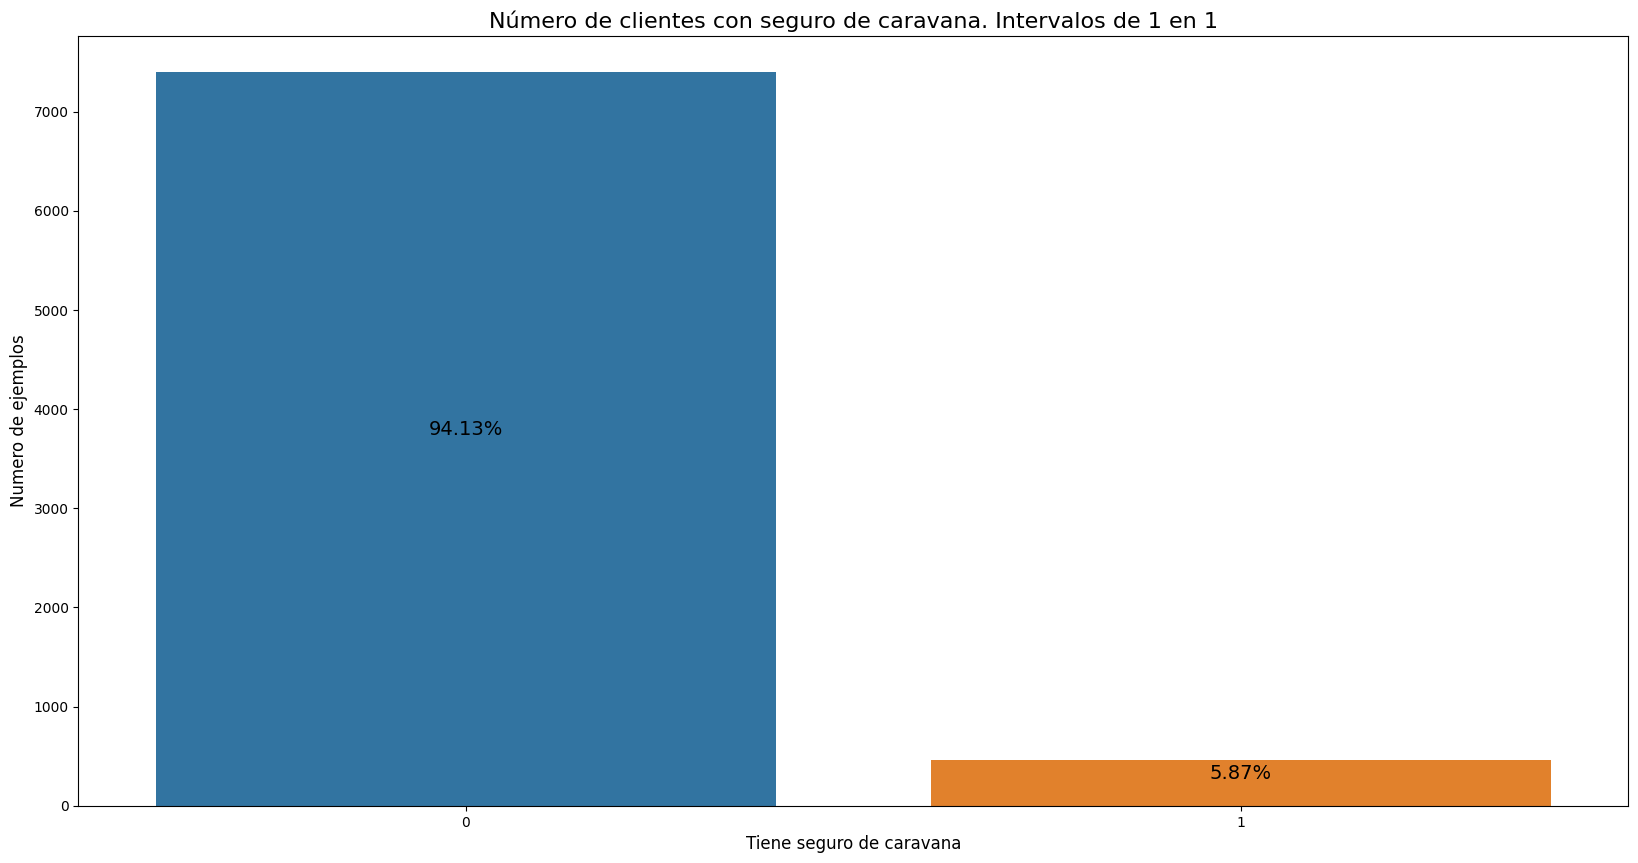

Estan desbalanceados. La mayoría no tienen seguro


In [ ]:
# Separamos los datos del atributo objetivo
X, Y = separar_datos(data_class) # Primero se separa en X e Y

# Dividir los datos en training y test usando la libreria scikit
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)

# Crear dataframes de test y train
train = join_(X_train, Y_train, data_class.columns)
test = join_(X_test, Y_test, data_class.columns)

# Visualizamos el objetivo
title = "Número de clientes con seguro de caravana"
xlabel = "Tiene seguro de caravana"
ylabel = "Numero de ejemplos"
intervalo = 1
percentil = 100

show_histogram(train, title , xlabel, ylabel, 14)

print("Estan desbalanceados. La mayoría no tienen seguro")
# Y_(data_class).hist(figsize=(20,20))
# plt.show()

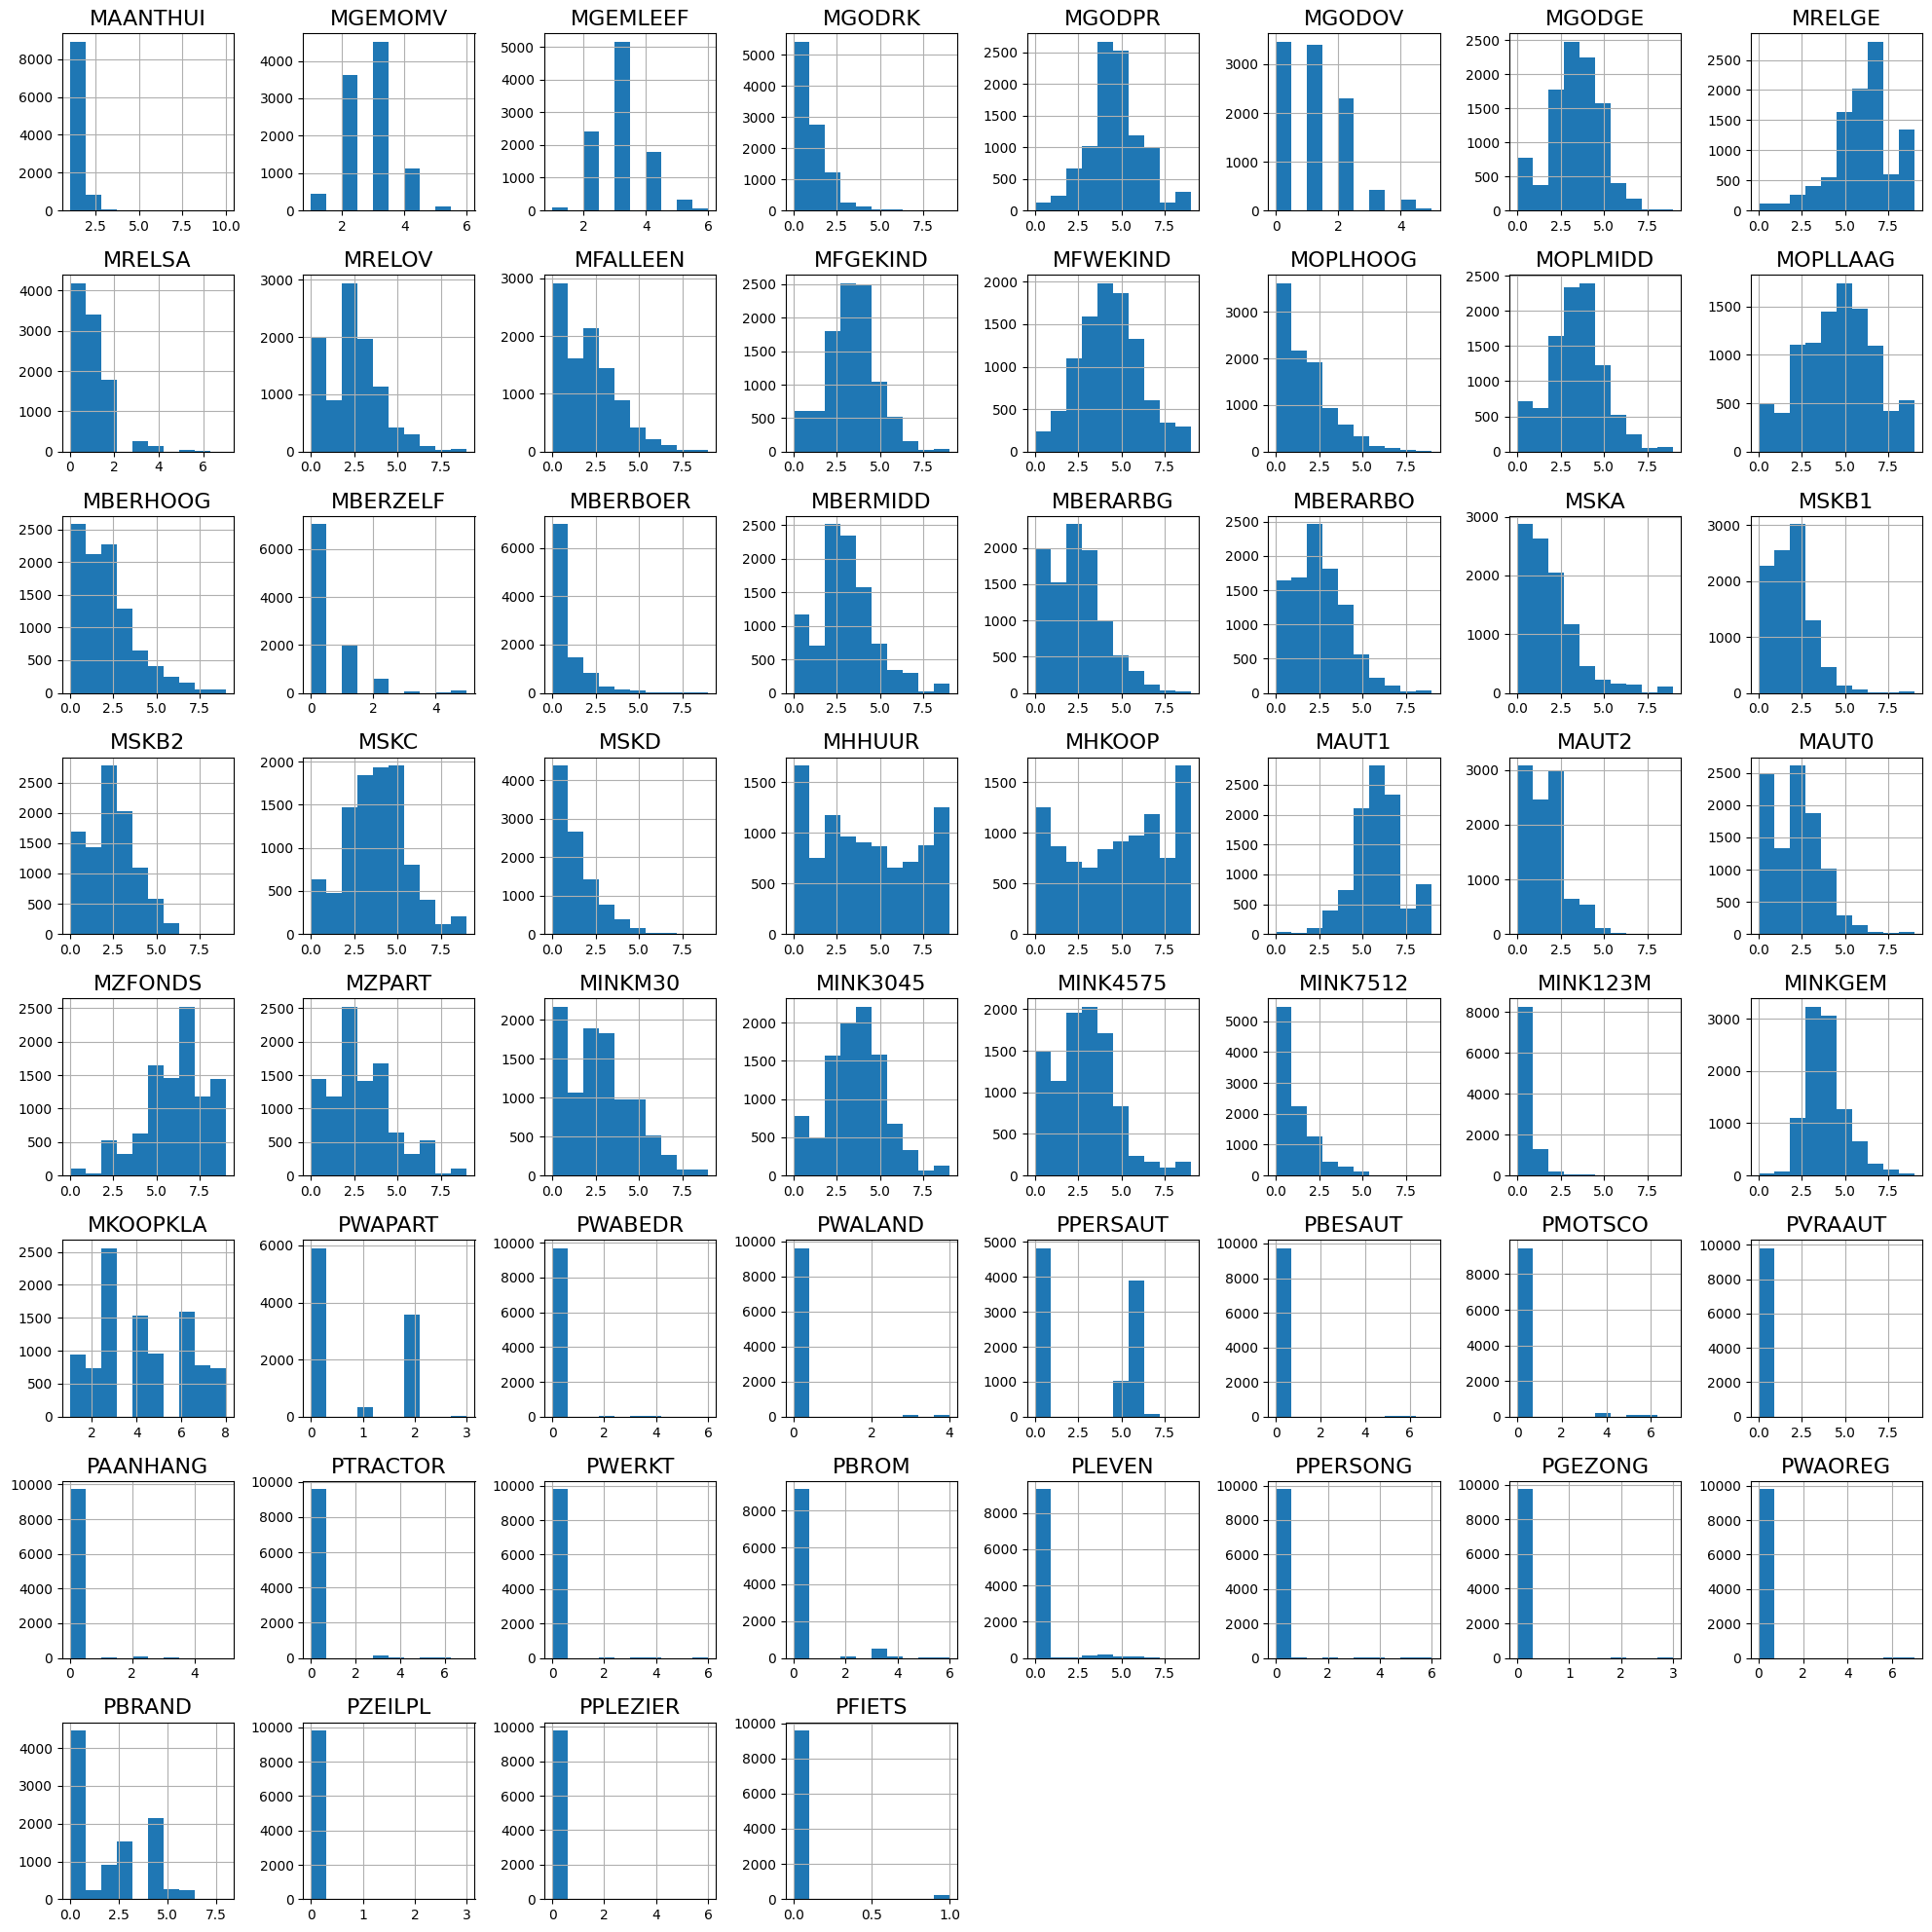

In [ ]:
data_class.iloc[:,0:60].hist(figsize=(20,20))
plt.tight_layout()
plt.show()

In [ ]:
# Muestra las variables continuas originales del atributo objetivo
tablaOriginal = crear_tabla_valores(train)
print("Información relevante del atributo objetivo original")
display(tablaOriginal.tail(1))

Información relevante del atributo objetivo original


,Media,Mediana,Desviación típica,Mínimo,Máximo,Percentil 10.0,Percentil 25.0,Percentil 50.0,Percentil 75.0,Percentil 90.0
CARAVAN,0.058674,0.0,0.235028,0,1,0.0,0.0,0.0,0.0,0.0


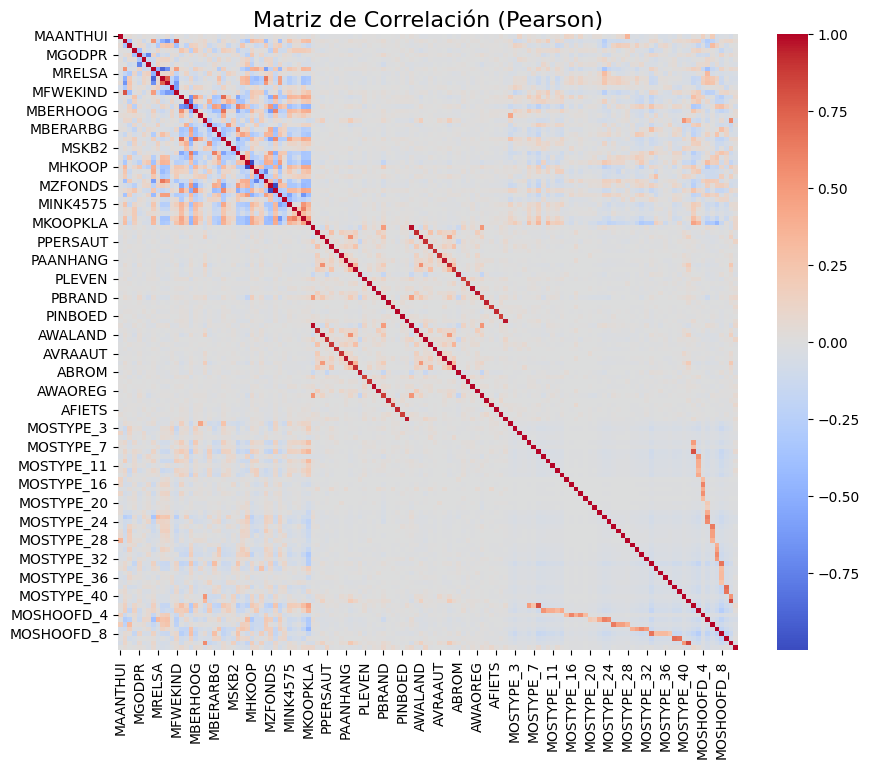

In [ ]:
# Visualizamos la correlacion de los datos

# Calcular la matriz de correlación de Pearson con las variables continuas
pearson_corr = train.corr(method='pearson')

# Calcular la matriz de correlación de Spearman
#spearman_corr = train.corr(method='spearman') # Redundante

# Crear un mapa de calor de la matriz de correlación de Pearson
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', annot_kws={"size": 8})
plt.title('Matriz de Correlación (Pearson)')
plt.show()

In [ ]:
# Obtenemos variables con una alta correlación
def get_most_correlated(pearson_corr, threshold):
  # Crear un diccionario para almacenar los pares de columnas con correlación superior a 0.9
  pares_corr = {}

  # Obtener las dimensiones del DataFrame
  num_filas, num_columnas = pearson_corr.shape

  # Iterar sobre las columnas del DataFrame
  for i in range(num_columnas):
      for j in range(i+1, num_columnas):
          # Verificar si la correlación es mayor a 0.95
          if abs(pearson_corr.iloc[i, j]) > threshold:
              # Almacenar el par de columnas con la correlación en el diccionario
              columna_1 = pearson_corr.columns[i]
              columna_2 = pearson_corr.columns[j]
              pares_corr[(columna_1, columna_2)] = pearson_corr.iloc[i, j]

  # Mostrar los pares de columnas con correlación superior a 0.9
  print("Numero de pares correlacionados: ", len(pares_corr))
  for pares, correlacion in pares_corr.items():
      columna_1, columna_2 = pares
      print(f"Columna 1: {columna_1}, Columna 2: {columna_2}, Correlación: {correlacion}")

  return pares_corr

In [ ]:
threshold = 0.9
# Calcular la matriz de correlación de Pearson
pearson_corr = train.corr(method='pearson')

# Obtenemos los pares más correlados
pares_corr = get_most_correlated(pearson_corr, threshold)

print("""\nPodemos observar que algunos atributos de pago de seguro vs numero de seguros
están muy relacionados\n""")

print("Atributos originales en los datos: ", train.shape[1])
# Eliminamos correlados
for par in pares_corr:
    columna_eliminar = par[0]
    train = train.drop([columna_eliminar], axis=1, errors='ignore')
    test = test.drop([columna_eliminar], axis=1, errors='ignore')

print("Atributos tras quitar correlados en los datos: ", train.shape[1])

# Comprobamos
print("\nComprobamos que se eliminan correctamente.")

# Recalcular la matriz de correlación de Pearson
pearson_corr = train.corr(method='pearson')

# Obtenemos los pares más correlados
pares_corr = get_most_correlated(pearson_corr, threshold)

Numero de pares correlacionados:  17
Columna 1: MHHUUR, Columna 2: MHKOOP, Correlación: -0.999643282752922
Columna 1: MZFONDS, Columna 2: MZPART, Correlación: -0.9993524742898049
Columna 1: PWAPART, Columna 2: AWAPART, Correlación: 0.9808027787960049
Columna 1: PWABEDR, Columna 2: AWABEDR, Correlación: 0.9249526751356336
Columna 1: PWALAND, Columna 2: AWALAND, Correlación: 0.9860287330042387
Columna 1: PPERSAUT, Columna 2: APERSAUT, Correlación: 0.9079708627599289
Columna 1: PMOTSCO, Columna 2: AMOTSCO, Correlación: 0.9174862866866859
Columna 1: PVRAAUT, Columna 2: AVRAAUT, Correlación: 0.9046386912469818
Columna 1: PAANHANG, Columna 2: AAANHANG, Correlación: 0.9651700438212052
Columna 1: PTRACTOR, Columna 2: ATRACTOR, Correlación: 0.9282090750946072
Columna 1: PBROM, Columna 2: ABROM, Correlación: 0.9663026139847132
Columna 1: PPERSONG, Columna 2: APERSONG, Correlación: 0.9046463327610172
Columna 1: PGEZONG, Columna 2: AGEZONG, Correlación: 0.9796693483455144
Columna 1: PWAOREG, Colum

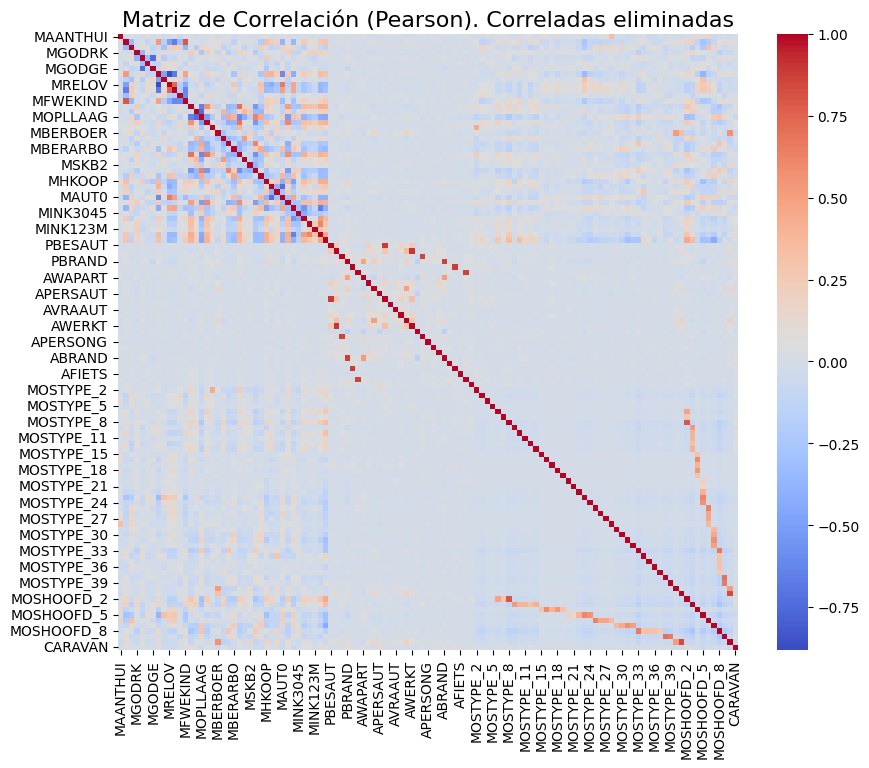

In [ ]:
# Crear un mapa de calor de la matriz de correlación de Pearson
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', annot_kws={"size": 8})
plt.title('Matriz de Correlación (Pearson). Correladas eliminadas')
plt.show()
# Iterar sobre las columnas del DataFrame

#### <font color='blue'>2)  Identificar qué conjuntos de hipótesis se emplearán y justificar dicha elección. 0.25 puntos.

Para la realización de la práctica se pide principalmente aplicar modelos lineanes. De los tres modelos propuestos, Regresión Lineal, Regresión Logística y Perceptron+Pocket vamos a aplicar la Regresión Logística y el Perceptron usando la versión Pocket.

La Regresión Logística permite estimar la probabilidad de una variable cualitativa binaria en función de una variable cuantitativa. Es por ello que el uso de este modelo es una de las principales aplicaciones para la clasificación binaria. En este caso, claramente estamos ante un problema de
**Clasificación Binaria** ya que el resultado buscado es hallar <font color='blue'>**YES** </font> o <font color='red'>**NO** </font>. No deja de ser una aplicación de Regresión, por tanto la asignación final se hace en función de las probabilidades predichas.

La decisión de aplicar la Regresión Logística y no la Lineal pese a ser posible ajustar matemáticamente la clasificación por Mínimos Cuadrados es que esta aproximación puede obtener valores de Y menores que 0, rompiendo así el hecho de que el rango debe estar entre [0, 1]. La Regresión Logística, en cambio, transforma este valor comprendiendo siempre el resultado en este rango.

$$
\sigma(x)=\frac{1}{1+e^{-x}} \quad \text{Función sigmoide}
$$

Por otro lado tenemos el uso del Perceptrón, que, podría decirse que el algoritmo de aprendizaje para clasificación binaria por excelencia. Podría incluso considerarse una especie de red neuronal muy simple, aunque no es el tema que concierne. Lo que hace este algoritmo es analizar una entrada
y predecir una salida. Para ello lo que hace es calcular una suma ponderada de las entradas y un sesgo. Esto sería la activación. Depende del valor de la Activación, retornará un valor 0 o un valor 1, si ocurre que esta es menor o igual a 0, o mayor que 0 respectivamente. Para el cálculo de los
coeficientes, se aplica el SGD (**Gradiente Descendente Estocástico**)

Este algoritmo tiene un inconveniente, y es que, además de tener un cómputo lento, es posible que nunca converja, por tanto hay que establecer un máximo de épocas (iteraciones) y un promedio de error como cota. Además necesita que queden fijados antes de ejecutarse unos pesos (coeficientes),
los cuales irán ayudando a calcular las salidas. Por convención, se inicializan a un valor muy pequeño.

#### <font color='blue'>3)  Si la base de datos define conjuntos de training y test, únalos en un solo conjunto y genere sus propios conjuntos. Describa y justifique el mecanismo de partición. 0.75 puntos.

Esta vez nos dan 3 ficheros diferentes:
- ticdata2000.txt: es el conjunto de entrenamiento
- ticeval2000.txt: es el conjunto de test
- tictgts2000.txt: contiene las etiquetas de test

El procedimiento de unión y separación se realiza en el punto 1, se detalla a continuación.

Primero se leen los 3 ficheros de forma independiente, se unen test con las etiquetas y posteriormente se une con train. Se realiza un mezclado de datos y se pasa al procedimiento de particionado.

Para realizar dicha partición se ha tomado el conjunto completo de datos y se han elegido qué porcentajes del total formarán parte de una parte y de otra. Se ha elegido que el 20 % formará parte del conjunto Test, mientras que el restante 80 % lo será del Train quedando:

- Train. 7857 elementos del conjunto de datos.
- Test. 1965 elementos.

Para hacer esto, en el primer apartado se ha hecho uso de la función de `sklearn`:

 `train_test_split(X, Y, test_size = 0.2, shuffle=True)`

 Indicando en sus parámetros el mezclado de datos mediante shuffle, de forma que el 80 % no sea los primeros elementos y el resto los últimos, si no que antes haga una mezcla de los mismos.

Dentro del conjunto de entrenamiento podemos aplicar diferentes técnicas como el leave one out, hold out o cross validation o una mezcla de varios. Vamos a analizar cada uno:

-  **Cross Validation (CV)**: En lugar de dividir el conjunto de datos en una única partición de entrenamiento y prueba, cross validation divide el conjunto de datos en k particiones o "folds" de tamaño similar. El objetivo es evaluar el rendimiento del modelo de forma más robusta, ya que se utiliza la totalidad de los datos en múltiples combinaciones de entrenamiento y prueba. Esto permite obtener una estimación más confiable del rendimiento del modelo y evaluar cómo se generaliza a datos no vistos.

- **Leave one out**: es una técnica de validación cruzada muy costosa computacionalmente, ya que implica entrenar el modelo tantas veces como el número de muestras en el conjunto de entrenamiento. En nuestro caso que hay unas 9.000 instancias de entrenamiento no es recomendable.

- **Hold out**: implica dividir el conjunto de datos en dos partes: entrenamiento y validación. Si los datos presentan una distribución no uniforme o existe una variabilidad significativa en los datos, la partición realizada en hold out puede introducir un sesgo en la evaluación del modelo. Y como hemos visto, nuestros datos tienen un desbalanceo importante por lo que no es recomendable usarlo. En cambio, el uso de cross validation permite evaluar el rendimiento del modelo en diferentes subconjuntos de datos, lo que ayuda a mitigar el impacto de esa variabilidad.

Los motivos extra por los que usar cross validation son:

 - Mayor aprovechamiento de los datos: ya que permite utilizar la totalidad de los datos de entrenamiento en múltiples iteraciones, lo que resulta en un mejor aprovechamiento del conjunto de entrenamiento disponible.

- Evaluación más fiable del modelo: al realizar múltiples particiones del conjunto de datos y promediar los resultados, CV proporciona una estimación más fiable del rendimiento del modelo. Permite evaluar cómo se generaliza el modelo en diferentes configuraciones de los datos y ayuda a mitigar el impacto de una partición de datos específica en los resultados finales.

- Ajuste de hiperparámetros: permite evaluar diferentes combinaciones de hiperparámetros en múltiples divisiones del conjunto de entrenamiento, lo que ayuda a seleccionar los mejores hiperparámetros de manera más confiable.

Se ha decidio utilizar CV. Para aplicarlo, se ha importado la función cross_val_score de Sklearn

`pred = cross_val_predict(classification, X, y, cv=5)`

Una vez obtenida la predicción se llama a la función propia de evaluate_model para calcular todas las métricas deseadas.

La función cross_val_score tiene varios parámetros que se pueden ajustar para personalizar el proceso de validación cruzada. Aquí tienes una descripción de los parámetros más importantes:

- estimator: Es el estimador o modelo que se utilizará para realizar la validación cruzada. Puede ser cualquier objeto que implemente los métodos fit y predict. En nuestro problema se usará la regresión logística.

- X: Son los datos de entrada o características que se utilizarán para entrenar y evaluar el modelo.

- y: Son las etiquetas o valores objetivo correspondientes a los datos de entrada.

- cv: Especifica la estrategia de validación cruzada a utilizar. Puede ser un entero para indicar el número de folds, por ejemplo cv=5 para 5-fold cross-validation.

In [ ]:
# la separacion de train se realiza al principio en el apartado 1

print("\tTamaño del Conjunto")
print("\t\t", X.shape)

print("\n\tTamaño del Train")
print("\t\t", X_train.shape)

print("\n\tTamaño del Test")
print("\t\t", X_test.shape)

# El cross validation se aplica en el apartado 7
# scores = cross_val_predict(classification, X, y, cv=5, scoring='accuracy')

	Tamaño del Conjunto
		 (9822, 131)

	Tamaño del Train
		 (7857, 131)

	Tamaño del Test
		 (1965, 131)


#### <font color='blue'>4)  Justifique todos los detalles del preprocesado de los datos (codificación, transformación, normalización, etc). Es decir, todas las manipulaciones sobre los datos iniciales que nos permitan fijar el conjunto de vectores de características que se usarán en el entrenamiento. 1 punto.

<font color='blue'>Nota: Las transformaciones no-lineales de las variables pueden definirse a partir de las potencias y
productos de potencias de las variables originales, conjuntos de polinomios ortogonales, etc. Si se
usan transformaciones no polinómicas de las variable como $log$, $\sqrt{()}$, $sin$, etc, debe justificar el
interés de las mismas.

En primer lugar, lo que se ha hecho es transformar las variables categóricas a variables numéricas. Los algoritmos matemáticos no pueden incluir objetos o cadenas como entrada a la hora de entrenar, es por eso que se realiza dicha transformación. Para conseguirla, ya que el modelo está cargado en una estructura de datos de tipo Pandas Dataframe es fácil realizar esto mediante la
función `get_dummies(datas, columns = categoricas, drop first = True)`. A esta función se le pasa el conjunto de datos (aun sin dividir en train y test). Además hay que pasar las columnas que son categóricas, ya que por sí solo no sabe cuales son. Por último, para no tener las columnas anteriores
categóricas se usa el parámetro drop first a true de forma que elimina la columna anterior categórica y deja la nueva numérica. Para obtener cuáles son las columnas que tienen datos categóricos miramos la documentación y encontramos que **MOSTYPE** y **MOSHOOFD** son categorías de cliente. Con todo esto se procede a su eliminación.

El siguiente paso en el preprocesamiento es eliminar aquellos datos sin varianza. Es una opción esencial para aumentar la calidad del modelo. Para esto se usa mi función propia remove_non_variability. Esta función solo trabaja con datos numéricos, así que es por ello que en primer lugar se transformaron las variables. El valor que recibe es la cota que se permite de varianza, es decir, aquellas características con un valor MENOR a este, quedan fuera del conjunto.

Sin embargo, antes de realizar esto es OBLIGATORIO normalizar los datos. Esto se realiza así debido a que todos los datos deben estar en la misma escala, si no la varianza puede estimarse de forma incorrecta entre qué es un valor alto y cual uno bajo. Para la normalización de datos, al igual que ocurrió en la Regresión se usa la función de sklearn StandardScaler().fit transform(X).

In [ ]:
def normalize(XTrain, XTest):
    # Crear un objeto StandardScaler
    scaler = StandardScaler()

    # Calcular la media y la desviación estándar del conjunto de entrenamiento
    scaler.fit(XTrain)

    # Aplicar la normalización a los conjuntos de entrenamiento y prueba utilizando los valores de entrenamiento
    train_norm = scaler.transform(XTrain)
    test_norm = scaler.transform(XTest)

    # Convertir los conjuntos normalizados de vuelta a DataFrames con los mismos nombres de columnas
    train_norm = pd.DataFrame(train_norm)
    test_norm = pd.DataFrame(test_norm)

    return train_norm, test_norm

# Normalizar datos
print("\n3. Se normalizan los datos mediante MinMaxScaler")
X_train_norm, X_test_norm = normalize(X_train, X_test)

# Mostrar las primeras filas del conjunto de entrenamiento original y normalizado
display(pd.DataFrame(X_train).head())
display(X_train_norm.head())


3. Se normalizan los datos mediante MinMaxScaler


,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,1,2,4,2,7,0,0,6,1,2,...,0,0,0,0,0,0,0,0,0,0
1,1,4,2,2,0,2,5,9,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,3,3,1,4,2,3,5,2,3,...,0,0,0,0,0,0,0,1,0,0
3,1,3,3,1,4,1,5,7,1,2,...,0,0,0,0,0,0,0,1,0,0
4,1,2,3,0,4,1,4,6,1,3,...,0,0,0,0,0,0,0,1,0,0


,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,-0.262278,-0.875418,1.261778,1.264796,1.375728,-1.033166,-2.042008,-0.103294,0.131409,-0.166221,...,-0.191164,-0.301825,-0.428116,-0.090623,-0.324135,-0.181286,-0.315674,-0.614570,-0.360352,-0.227303
1,-0.262278,1.684374,-1.237287,1.264796,-2.689587,0.931637,1.088051,1.489081,-0.907304,-1.341210,...,-0.191164,-0.301825,2.335817,-0.090623,-0.324135,-0.181286,-0.315674,-0.614570,-0.360352,-0.227303
2,-0.262278,0.404478,0.012246,0.285828,-0.366550,0.931637,-0.163973,-0.634085,1.170122,0.421273,...,-0.191164,-0.301825,-0.428116,-0.090623,-0.324135,-0.181286,-0.315674,1.627155,-0.360352,-0.227303
3,-0.262278,0.404478,0.012246,0.285828,-0.366550,-0.050764,1.088051,0.427498,0.131409,-0.166221,...,-0.191164,-0.301825,-0.428116,-0.090623,-0.324135,-0.181286,-0.315674,1.627155,-0.360352,-0.227303
4,-0.262278,-0.875418,0.012246,-0.693140,-0.366550,-0.050764,0.462039,-0.103294,0.131409,0.421273,...,-0.191164,-0.301825,-0.428116,-0.090623,-0.324135,-0.181286,-0.315674,1.627155,-0.360352,-0.227303


In [ ]:
def remove_non_variability(XTrain, XTest, threshold=0):
    # Crear un objeto StandardScaler
    nonvariable = VarianceThreshold(0.6)

    # Calcular la media y la desviación estándar del conjunto de entrenamiento
    nonvariable.fit(XTrain)

    # Aplicar la normalización a los conjuntos de entrenamiento y prueba utilizando los valores de entrenamiento
    Xtrain_nv = nonvariable.transform(XTrain)
    Xtest_nv = nonvariable.transform(XTest)

    return Xtrain_nv, Xtest_nv

print("Dimension antes de eliminar no variabilidad:",X_train_norm.shape)

# Eliminar datos sin variabilidad (no son discriminantes)
X_train_nv, X_test_nv = remove_non_variability(X_train_norm, X_test_norm)

print("Dimension tras eliminar no variabilidad: ", X_train_nv.shape)

Dimension antes de eliminar no variabilidad: (7857, 131)
Dimension tras eliminar no variabilidad:  (7857, 131)


Tras normalizar y tratar de eliminar aquellos datos sin variablidad, se procede a eliminar los Outliers. Estos son aquellos valores que “mienten” sobre la respuesta buscada. Los Outliers pueden terminar afectando notoriamente a la aplicación de PCA, de forma que si no se contemplan antes, se eliminen muchas más complejidad que la que debería eliminarse. Para ello se usa la función `OneClassSVM(nu=0.01)` de svm (Support Vector Machine). Esta función genera el modelo permitiendo un máximo de error de entrenamiento que es la variable nu y aplicando su función `fit_predict(X)` devuelve aquellos elementos que se consideran Outliers, es decir, anomalías en los datos. Una vez estos se eliminen se podría decir que los datos contienen todos la misma distribución
normal. Tras realizar la búsqueda de outliers el conjunto de datos se ha reducido de 7857 instancias a 7664.

In [ ]:
print("Los outliers pueden afectar notoriamente al aplicar PCA.")
print("Vamos a identificar esos outliers y eliminarlos\n")

# Identificar outliers en el conjunto de entrenamiento usando One-Class SVM
outlrs = OneClassSVM(nu=0.01)
outlrs.fit(X_train_nv)

# Predecir outliers en los conjuntos de entrenamiento y prueba
yhat_train = outlrs.predict(X_train_nv)
yhat_test = outlrs.predict(X_test_nv)

# Seleccionar filas que NO son outliers
mask_train = yhat_train != -1
mask_test = yhat_test != -1

# Filtrar el conjunto de entrenamiento y prueba eliminando los outliers
X_train_outlrs, Y_train_outlrs = X_train_nv[mask_train, :], Y_train[mask_train]
X_test_outlrs, Y_test_outlrs = X_test_nv[mask_test, :], Y_test[mask_test]

print("\n\tDimensión de los datos antes de eliminar los outliers")
print("\t\t", X_train_nv.shape)

print("\n\tDimensión de los datos tras eliminar los outliers")
print("\t\t", X_train_outlrs.shape)

Los outliers pueden afectar notoriamente al aplicar PCA.
Vamos a identificar esos outliers y eliminarlos


	Dimensión de los datos antes de eliminar los outliers
		 (7857, 131)

	Dimensión de los datos tras eliminar los outliers
		 (7664, 131)


Ahora ya sí, tras transformar los datos y dividir en Train y Test los mismos, se aplica PCA.

Tal y como se menciono en la Regresión, este sirve para reducir la complejidad del problema. Tras aplicarlo queda como resultado:

In [ ]:
def apply_PCA(XTrain, XTest, value):
  print("\nDimensiones antes de aplicar PCA", XTrain.shape[1])
  # Crear instancia del modelo PCA con el valor especificado
  pca = PCA(value)

  # Ajustar el modelo PCA a los datos de entrenamiento
  pca.fit(XTrain)

  # Transformar los datos de entrenamiento utilizando el modelo PCA
  XTrain = pca.transform(XTrain)

  print("\nDimensiones después de aplicar PCA", XTrain.shape[1])

  # Transformar los datos de prueba utilizando el modelo PCA
  XTest = pca.transform(XTest)

  return XTrain, XTest

# Aplicar PCA
X_train_prep, X_test_prep = apply_PCA(X_train_outlrs, X_test_outlrs, 0.99)

# Combinar X e Y
train_prep = join_(X_train_prep , Y_train_outlrs)
test_prep = join_(X_test_prep, Y_test_outlrs)

# Obtenemos los conjuntos finales para probar los modelos
X_train_prep = X_(train_prep)
Y_train_prep = Y_(train_prep)
X_test_prep = X_(test_prep)
Y_test_prep = Y_(test_prep)

print(f"\nDimensiones originales: {train.shape}")
print(f"Dimensiones finales: {train_prep.shape}")




Dimensiones antes de aplicar PCA 131

Dimensiones después de aplicar PCA 91

Dimensiones originales: (7857, 115)
Dimensiones finales: (7664, 92)


#### <font color='blue'>5)  Justifique las métricas de error y la función de pérdida a usar. Discutir su idoneidad para el problema. 0.5 puntos.

Para evaluar el modelo se ha usado la propia función **score** que proporciona el modelo de Regresión Logística, pero además se ha calculado la precisión del modelo mediante la función **accuracy score (Y, predictions)** de sklearn. Esta accuracy básicamente lo que hace es calcular el número de predicciones correctas. No obstante, no es del todo fiable, ya que hay que ver también si
ese valor se corresponde con la precisión real de cada clase, es decir, supóngase que hay un conjunto de datos donde para una clase se han acertado el 99 % pero para otra un 0 %, y la precisión que devuelve el modelo en su conjunto es del 99 % o un valor muy próximo a ese. En realidad no es un
valor representativo, ya que de la clase 2 no ha sido capaz de clasificar nada.

Esto es muy común cuando los datos están muy desbalanceados, de forma que, por ejemplo, habiendo dos clases (un problema binario) para la clase A hay 1000 muestras, mientras que para la clase B hay solo 10. Sería mucho pedirle al modelo que fuese capaz de aprender a clasificar valores para la clase B cuando apenas tiene instancias suficientes de las que aprender. Es por ello, que además de mostrar el accuracy se muestra también la Matriz de Resultados donde se muestra toda la precisión e información de cada clase, y además la Matriz de Confusión. Este última permite comprobar cuántos **Falsos Negativos** y cuántos **Falsos Positivos** han ocurrido durante la predicción usando el conjunto de Test. Para obtener dichas matrices, de nuevo se importan de la librería sklearn los métodos **classification report(Y, predictions) y confusion matrix(Y, predictions)**

La **Matriz de Resultados** muestra las siguientes métricas:

- **Accuracy**. Es el número total de predicciones acertadas dividido por el número total de elementos. Como se ha explicado, hay que tener cuidado con este valor, por sí solo, puede que no aporte nada.

- **Precision**. Aunque en español el término significa lo mismo que accuracy no significan lo mismo. Esta precisión hace referencia a cuánto de confiable es el modelo para ser capaz de responder si un punto pertenece a una clase.

- **Recall**. Expresa como de bien es capaz el modelo de detectar una clase.

- **F1-Score**. Combina en forma de media la precision y el recall. Cuando más próximo a 0 en un rango [0, 1] (como los demás valores) peor ha sido el resultado.

#### <font color='blue'>6)  Discuta todos los parámetros y el tipo de regularización usada en el ajuste de los modelos seleccionados. Justificar la idoneidad de la regularización elegida. 1 punto.

Respecto la Regularización, en este caso no es posible aplicar Lasso, a diferencia de lo que ocurría en el problema de Regresión que era posible aplicar ambas. ¿Por qué? Es sencillo. Lasso optimiza mediante Mínimos Cuadrados, y por definición, por tanto, no es posible aplicar Lasso a
en una función logística. Al menos no es aplicable de forma standard, para poder aplicarlo se debe configurar un parámetro llamado solver en la función y darle un valor liblinear o SAGA. Esta es la única forma de aplicar la Regularización Lasso.

El otro tipo de Regularización que se ha aplicado ha sido Ridge. A diferencia de lo comentado en la parte de Regresión, para poder aplicar estos tipos de Regularización, esta vez no se importan los métodos desde sklearn si no que se hace mediante la parametrización de la llamada que crea el modelo de Regresión Logística, es decir `LogisticRegression(penalty=pen, solver=solvr, max_iter=1500)`.

- **Penalty**. Mediante este parámetro se indica el tipo de Regularización a aplicar, siendo L1 Lasso y L2 Ridge.

- **Solver**. Es la configuración que, en este caso, eligiendo liblinear permite ejecutar la Regularización Lasso en modelos de Regresión Logística. Para Ridge se usa lbfgs.

- **Max Iter**. Como su nombre indica, se podría considerar como el Stop Iteration del modelo.

In [ ]:
def evaluate_model(YTest, predictions, score):
  """
  Evalúa el rendimiento del modelo utilizando métricas como la precisión, el informe de clasificación y la matriz de confusión.

  Parámetros:
  - YTest: Valores reales del conjunto de prueba.
  - predictions: Valores predichos por el modelo.
  - score: Puntuación del modelo.
  """

  # Calcular y mostrar la precisión del modelo
  print("\n\tAccuracy: ", accuracy_score(YTest, predictions))
  print("\n\tLa precisión del modelo es de {}%".format(score))

  # Calcular y mostrar el informe de clasificación
  result = classification_report(YTest, predictions, zero_division=0)
  print('\n\tInforme de clasificación\n')
  print(result)

  # Calcular y mostrar la matriz de confusión
  print("\n\tMatriz de confusión\n")
  print(confusion_matrix(YTest, predictions))

#### <font color='blue'>7)  Selección de la mejor hipótesis para el problema. Discuta el enfoque seguido y el criterio de selección usado. ¿Cúal es su error $E_{out}$? 1 punto.

Una vez se tiene todo el conjunto de datos preprocesado falta aplicar el modelo de Regresión Logística para aprender la función de predecir cuándo la compañía de seguros debe dar un seguro de caravana a un cliente.

Para esto, se importa la función LogisticRegression() de la librería sklearn y se configuran sus parámetros. En primer lugar se va a ejecutar el modelo de Regresión Logística junto con la Regularización Ridge.

In [ ]:
# REGRESIÓN LOGÍSTICA + RIDGE - Sin balanceado

penalty = "l2"  # Tipo de penalización (l1, l2, elasticnet, none)
solver = "lbfgs"  # Algoritmo solver utilizado para la optimización (lbfgs, saga, newton-cg, liblinear)
max_iter = 1500  # Número máximo de iteraciones para la convergencia del modelo
class_weight = None  # Peso asignado a las clases (None para igual peso)

# Crear una instancia del modelo de Regresión Logística con los parámetros especificados
logm = LogisticRegression(penalty=penalty, solver=solver, max_iter=max_iter, class_weight=class_weight)

# Ajustar el modelo utilizando los datos de entrenamiento preprocesados
model = logm.fit(X_train_prep, Y_train_prep)

# Realizar predicciones en los datos de prueba preprocesados
predictions = model.predict(X_test_prep)

# Calcular el score de precisión del modelo
score_logreg = round(logm.score(X_test_prep, Y_test_outlrs) * 100, 2)

# Imprimir la forma de los datos de prueba preprocesados
print(X_test_prep.shape)

# Evaluar el modelo utilizando diferentes métricas
evaluate_model(Y_test_prep, predictions, score_logreg)


(1876, 91)

	Accuracy:  0.9371002132196162

	La precisión del modelo es de 93.71%

	Informe de clasificación

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1758
         1.0       0.00      0.00      0.00       118

    accuracy                           0.94      1876
   macro avg       0.47      0.50      0.48      1876
weighted avg       0.88      0.94      0.91      1876


	Matriz de confusión

[[1758    0]
 [ 118    0]]


Y efectivamente, aquí ocurre lo mencionado antes cuando se tiene un conjunto de datos desbalanceado. La precisión del modelo es de un 94% casi, sin embargo, el modelo no es capaz de reconocer a la clase 1 con un 0% de forma individual, siendo además todos los elementos falsos negativos. A simple vista puede parecer un resultado gratificante, sin embargo la realidad es muy distinta.

Debido a esta situación se intenta aplicar un balanceo de datos. Esta técnica no es especialmente recomendada, ya que para realizar esto no queda más remedio que hacer dos cosas:

1. **Supresión de Datos.** Esto es básicamente lo que se hizo en el problema de Regresión. Es cierto que mejoró el error notoriamente pero, un gran precio a pagar es el de eliminar datos que sean esenciales a la hora de aprender un modelo.
2. **Creación de Datos en la clase minoritaria.** Esta segunda opción podría parecer coherente, sin embargo, existe la posibilidad de generar un overfitting desmesurado.

La opción que se ha barajado después de ver qué posibilidades era mejor ha sido aplicar la Regresión Logística ajustando un parámetro más, el class weight. Este parámetro lo que haces es nivelar de una forma no muy abrupta la clase más minoritaria de forma que pueda intentarse así conseguir una mayor representatividad.

In [ ]:
# REGRESIÓN LOGÍSTICA + RIDGE - Balanceando las clases minoritarias con Class_Weight Balanced

penalty = "l2"  # Tipo de penalización (l1, l2, elasticnet, none)
solver = "lbfgs"  # Algoritmo solver utilizado para la optimización (lbfgs, saga, newton-cg, liblinear)
class_weight = "balanced"  # Peso asignado a las clases (balanced para equilibrar las clases)

# Crear una instancia del modelo de Regresión Logística con balanceo de clases y los parámetros especificados
logm_balanced = LogisticRegression(penalty=penalty, solver=solver, max_iter=1500, class_weight=class_weight)

# Ajustar el modelo utilizando los datos de entrenamiento preprocesados con clases balanceadas
model = logm_balanced.fit(X_train_prep, Y_train_outlrs)

# Realizar predicciones en los datos de prueba preprocesados
predictions = model.predict(X_test_prep)

# Calcular el score de precisión del modelo
score_logreg = round(logm_balanced.score(X_test_prep, Y_test_outlrs) * 100, 2)

# Imprimir la forma de los datos de prueba preprocesados
print(X_test_prep.shape)

# Evaluar el modelo utilizando diferentes métricas
evaluate_model(Y_test_outlrs, predictions, score_logreg)

# Imprimir un comentario adicional sobre el balanceo de clases
print("\nIntentando balancear la clase minoritaria ha conseguido que haya un mayor número de falsos positivos\n\tpara la clase 0 aunque ahora la clase 1 está mejor representada")

(1876, 91)

	Accuracy:  0.6775053304904051

	La precisión del modelo es de 67.75%

	Informe de clasificación

              precision    recall  f1-score   support

           0       0.97      0.68      0.80      1758
           1       0.12      0.65      0.20       118

    accuracy                           0.68      1876
   macro avg       0.54      0.67      0.50      1876
weighted avg       0.91      0.68      0.76      1876


	Matriz de confusión

[[1194  564]
 [  41   77]]

Intentando balancear la clase minoritaria ha conseguido que haya un mayor número de falsos positivos
	para la clase 0 aunque ahora la clase 1 está mejor representada


Se ha perdido cerca de un 30 % de precisión con el modelo ajustado, sin embargo, ¿es realmente una pérdida? Es cierto que ahora hay más falsos positivos que antes, sin embargo la precisión de la clase 0 sigue siendo realmente prometedora, mientras que ahora la clase 1 ha aumentado su poder
clasificatorio individual. El número de falsos negativos ha disminuido considerablemente ajustándose mejor ambas representaciones de las clases. Parece ser que ha sido una buena opción el intentar balancear la clase minoritaria, aunque haya supuesto obtener más falsos positivos. Sin embargo,
no es que haya empeorado la clase 0 como tal. Como se ha comentado siempre en clase, hay que intentar buscar un promedio entre lo malo y lo bueno.

Por último, para finalizar la Regresión Logística, se ha aplicado el mismo procedimiento pero esta vez haciendo uso de la Regularización Lasso. Sin embargo, no ha habido cambio ninguno respecto a la anterior ejecución.

In [ ]:
# REGRESIÓN LOGÍSTICA + LASSO - Balanceando las clases minoritarias con Class_Weight Balanced
penalty = "l2"  # Tipo de penalización (l1, l2, elasticnet, none)
solver = "liblinear"  # Algoritmo solver utilizado para la optimización (liblinear, saga)
class_weight = "balanced"  # Peso asignado a las clases (balanced para equilibrar las clases)

# Crear una instancia del modelo de Regresión Logística con balanceo de clases y los parámetros especificados
logm_balanced = LogisticRegression(penalty=penalty, solver=solver, max_iter=1500, class_weight=class_weight)

# Ajustar el modelo utilizando los datos de entrenamiento preprocesados con clases balanceadas
model = logm_balanced.fit(X_train_prep, Y_train_prep)

# Realizar predicciones en los datos de prueba preprocesados
predictions = model.predict(X_test_prep)

# Calcular el score de precisión del modelo
score_logreg = round(logm_balanced.score(X_test_prep, Y_test_prep) * 100, 2)

# Imprimir la forma de los datos de prueba preprocesados
print(X_test_prep.shape)

# Evaluar el modelo utilizando diferentes métricas
evaluate_model(Y_test_prep, predictions, score_logreg)

# Imprimir un comentario adicional sobre el balanceo de clases
print("\nIntentando balancear la clase minoritaria ha conseguido que haya un mayor número de falsos positivos\n\tpara la clase 0 aunque ahora la clase 1 está mejor representada")


(1876, 91)

	Accuracy:  0.6775053304904051

	La precisión del modelo es de 67.75%

	Informe de clasificación

              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80      1758
         1.0       0.12      0.65      0.20       118

    accuracy                           0.68      1876
   macro avg       0.54      0.67      0.50      1876
weighted avg       0.91      0.68      0.76      1876


	Matriz de confusión

[[1194  564]
 [  41   77]]

Intentando balancear la clase minoritaria ha conseguido que haya un mayor número de falsos positivos
	para la clase 0 aunque ahora la clase 1 está mejor representada


Si probamos con cross validation observamos que los resultados obtenidos son casi idénticos

In [ ]:
# REGRESIÓN LOGÍSTICA + RIDGE + CV - Balanceando las clases minoritarias con Class_Weight Balanced

penalty = "l2"  # Tipo de penalización (l1, l2, elasticnet, none)
solver = "lbfgs"  # Algoritmo solver utilizado para la optimización (lbfgs, saga, ...)
class_weight = "balanced"  # Peso asignado a las clases (balanced para equilibrar las clases)

# Crear una instancia del modelo de Regresión Logística con balanceo de clases y los parámetros especificados
logm_balanced = LogisticRegression(penalty=penalty, solver=solver, max_iter=1500, class_weight=class_weight)

# Ajustar el modelo utilizando los datos de entrenamiento preprocesados con clases balanceadas
model = logm_balanced.fit(X_train_prep, Y_train_prep)

# Realizar la validación cruzada en el modelo de regresión logística
pred = cross_val_predict(model, X_test_prep, Y_test_prep, cv=5)

# Calcular el score de precisión del modelo en los datos de prueba
score_logreg = round(logm_balanced.score(X_test_prep, Y_test_prep) * 100, 2)

# Imprimir la forma de los datos de prueba preprocesados
print(X_test_prep.shape)

# Evaluar el modelo utilizando diferentes métricas
evaluate_model(Y_test_prep, pred, score_logreg)

# Imprimir un comentario adicional sobre el balanceo de clases
print("\nIntentando balancear la clase minoritaria ha conseguido que haya un mayor número de falsos positivos\n\tpara la clase 0 aunque ahora la clase 1 está mejor representada")

(1876, 91)

	Accuracy:  0.7158848614072495

	La precisión del modelo es de 67.75%

	Informe de clasificación

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83      1758
         1.0       0.12      0.53      0.19       118

    accuracy                           0.72      1876
   macro avg       0.54      0.63      0.51      1876
weighted avg       0.91      0.72      0.79      1876


	Matriz de confusión

[[1281  477]
 [  56   62]]

Intentando balancear la clase minoritaria ha conseguido que haya un mayor número de falsos positivos
	para la clase 0 aunque ahora la clase 1 está mejor representada


In [ ]:
# REGRESIÓN LOGÍSTICA + LASSO + CV - Balanceando las clases minoritarias con Class_Weight Balanced

penalty = "l2"  # Tipo de penalización (l1, l2, elasticnet, none)
solver = "liblinear"  # Algoritmo solver utilizado para la optimización (liblinear, saga, ...)
class_weight = "balanced"  # Peso asignado a las clases (balanced para equilibrar las clases)

# Crear una instancia del modelo de Regresión Logística con balanceo de clases y los parámetros especificados
logm_balanced = LogisticRegression(penalty=penalty, solver=solver, max_iter=1500, class_weight=class_weight)

# Ajustar el modelo utilizando los datos de entrenamiento preprocesados con clases balanceadas
model = logm_balanced.fit(X_train_prep, Y_train_prep)

# Realizar la validación cruzada en el modelo de regresión logística
pred = cross_val_predict(model, X_test_prep, Y_test_prep, cv=5)

# Calcular el score de precisión del modelo en los datos de prueba
score_logreg = round(logm_balanced.score(X_test_prep, Y_test_prep) * 100, 2)

# Imprimir la forma de los datos de prueba preprocesados
print(X_test_prep.shape)

# Evaluar el modelo utilizando diferentes métricas
evaluate_model(Y_test_prep, pred, score_logreg)

# Imprimir un comentario adicional sobre el balanceo de clases
print("\nIntentando balancear la clase minoritaria ha conseguido que haya un mayor número de falsos positivos\n\tpara la clase 0 aunque ahora la clase 1 está mejor representada")

(1876, 91)

	Accuracy:  0.7164179104477612

	La precisión del modelo es de 67.75%

	Informe de clasificación

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83      1758
         1.0       0.12      0.54      0.19       118

    accuracy                           0.72      1876
   macro avg       0.54      0.64      0.51      1876
weighted avg       0.91      0.72      0.79      1876


	Matriz de confusión

[[1280  478]
 [  54   64]]

Intentando balancear la clase minoritaria ha conseguido que haya un mayor número de falsos positivos
	para la clase 0 aunque ahora la clase 1 está mejor representada


#### <font color='blue'>8)  Construya las curvas de aprendizaje del modelo, y discuta la calidad del ajuste obtenido a la vista de la conducta de dichas curvas. 0.5 puntos.

Apreciando simplemente las Curvas de Aprendizaje, en este caso no sería posible determinar con certeza que de verdad es mejor aquel modelo donde solo se aplica Ridge junto a la Regresión Logística. Es cierto que tiene un mayor porcentaje de precisión, sin embargo, la pregunta es, ¿está dispuesto a perder esa representación de una clase en un problema de Clasificación Binaria?

No obstante, se puede asegurar que no existe Overfitting ya que las curvas coinciden. Comienza no estando bien ajustado, hasta que termina de ajustarse, aunque no de una forma perfecta, ya que existe el error aunque bastante bajo. Aun así, como se ha mencionado, hay que seguir teniendo en cuenta los falsos positivos obtenidos y los falsos negativos, así como lo poco representativa que es una clase en Regresión Logística.

In [ ]:
def show_learningCurve(X_train, Y_train, model_, titulo, scr_ = "accuracy", cv_ = 10, trn_size_ = np.linspace(0.01, 1.0, 50)):
  """
  Muestra la curva de aprendizaje del modelo utilizando diferentes tamaños de conjunto de entrenamiento.

  Parámetros:
  - XTrain: Características del conjunto de entrenamiento.
  - YTrain: Objetivo del conjunto de entrenamiento.
  - model_: Modelo de aprendizaje a evaluar.
  - titulo: Título del gráfico.
  - cv_: Número de subdivisiones en la estrategia de validación cruzada.
  - scr_: Métrica de evaluación utilizada.
  - trn_size_: Tamaños del conjunto de entrenamiento para los que se calcula el puntaje.
  """
  # Se calcula la curva de aprendizaje
  sizes, training_scores, testing_scores = learning_curve(model_, X_train, Y_train, cv=cv_, scoring=scr_, train_sizes=trn_size_)

  # Cálculo de la media de los puntajes de entrenamiento y validación cruzada
  mean_training = np.mean(training_scores, axis=1)
  mean_testing = np.mean(testing_scores, axis=1)

  # Graficar la curva de aprendizaje
  plt.plot(sizes, mean_training, '--', color="b", label="Training score")
  plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")

  plt.title(titulo)
  plt.xlabel("Training Set Size")
  plt.ylabel(scr_)
  plt.legend(loc="best")
  plt.tight_layout()
  plt.show()

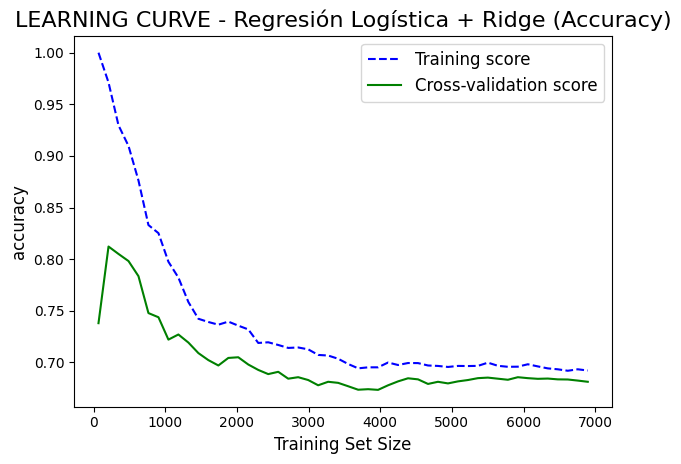

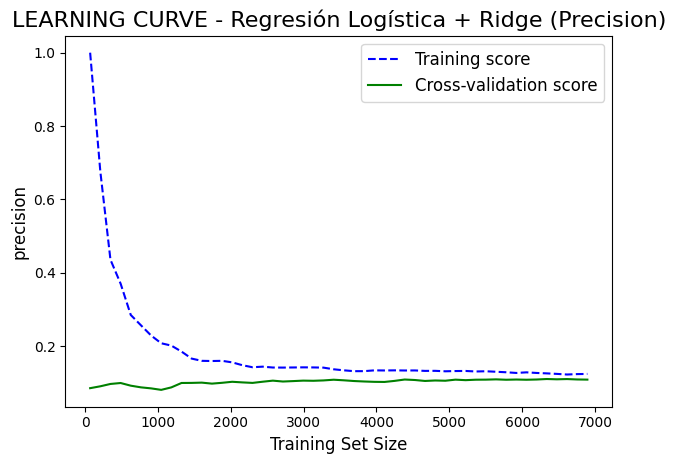

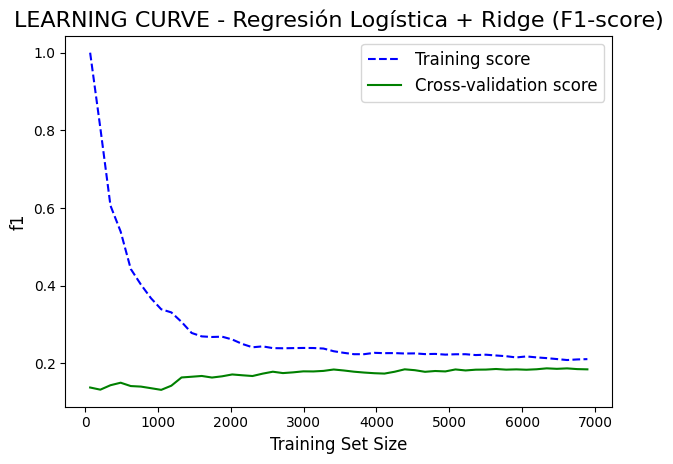

In [ ]:
show_learningCurve(X_train_prep, Y_train_prep, logm_balanced, "LEARNING CURVE - Regresión Logística + Ridge (Accuracy)")
show_learningCurve(X_train_prep, Y_train_prep, logm_balanced, "LEARNING CURVE - Regresión Logística + Ridge (Precision)", scr_='precision')
show_learningCurve(X_train_prep, Y_train_prep, logm_balanced, "LEARNING CURVE - Regresión Logística + Ridge (F1-score)", scr_='f1')

#### <font color='blue'>9)  Suponga ahora que Ud. debe realizar este ajuste para una empresa que le ha proporcionado los datos, sin distinción entre training y test. ¿Cúal sería el mejor modelo que les propondría, y qué error  $E_{out}$ les diría que tiene? Justifique todas las decisiones. 0.5 puntos.

El proceso que seguiría para contemplar la validez de los datos, así como el trato a los mismos para su uso sería el que se ha ido comentando durante el desarrollo de los puntos anteriores. El paso más importante es eliminar aquellos datos que no aporten nada, bien por su nulo valor en las
características, o bien por su baja varianza.

En este caso, cuando ocurre que hay valores categóricos, es importante transformarlos a valores numéricos con los que se pueda estudiar un comportamiento y se pueda realizar siempre un análisis competente.

Tal y como se ha mencionado, en el caso de problemas de clasificación no debería bastar solo y conformarse con valorar la precisión del modelo en su totalidad, pues puede ocurrir el caso de que se estén despreciando algunas clases. En este caso, sin ir más lejos, la precisión es de un 93%
tras aplicar simplemente la Regresión Logística, sin embargo la representación de la clase 1 era nula. Suponiéndose en este caso en cuestión sería como tener que decidir entre aquel que ya es un cliente y un potencial cliente. ¿Hay acaso alguna de las opciones que tenga menos peso? Un cliente, por serlo no es menos importante, es al final una fuente de ingreso para la empresa mientras lo sea,
pero, ¿y el que no es cliente? Sigue siendo igual de importante, ya que lo que es necesario estudiar es como atraer a ese posible futuro cliente.

A modo de conclusión y opinión personal, el modelo que mejor clasifica los datos es aquel en el que se aplica Ridge con un Balanceo de Datos (o Lasso con ese balanceo de datos, ya que no mejora ni empeora) ya que se consigue una representación equitativa de ambas clases en mayor medida.

A costa de sacrificar un número de falsos positivos, se obtienen verdaderos negativos en mayor cantidad, que, a mi juicio es mucho más importante tratándose de la clase minoritaria. Poniendo en un punto opuesto, ¿qué sentido tendría tener un modelo cuya precisión sea del 90 % o más y no fuese capaz de representar a las clases minoritarias? Aun así, como afirmación final, pese a los datos tan desbalanceados que se han proporcionado, un valor del modelo del 80% aproximadamente, me parece bastante aceptable.